In [1]:
# %load std_libraries.py
# If I make many files here, would be good to do this
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\BMH_work\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir_rna_seq = location_dict[location_input]
print("rna_seq base directory is " + base_dir_rna_seq)

if sys.path[-1] != base_dir_rna_seq:
    sys.path.append(base_dir_rna_seq)
    print("Added " + base_dir_rna_seq + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook

base_dir = os.path.normpath("C:/Users/BMH_work/Google Drive/UCSF/Yeast_colony_drop_seq")
data_processing_dir = base_dir + os.sep + "data" + os.sep
#base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as mpl_colorbar
import matplotlib.colors as mpl_colors
#import matplotlib.colormap as cm
#from matplotlib_venn import venn2
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
#import statsmodels.graphics.gofplots as stats_graph
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.SeqRecord import SeqRecord
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

what computer are you on? a = Bens, b = gpucluster, c = other   a
rna_seq base directory is C:\Users\BMH_work\github\expression_broad_data
Added C:\Users\BMH_work\github\expression_broad_data to path: 
['', 'C:\\Users\\BMH_work\\github\\ico_seq', 'C:\\Users\\BMH_work\\Anaconda3\\python37.zip', 'C:\\Users\\BMH_work\\Anaconda3\\DLLs', 'C:\\Users\\BMH_work\\Anaconda3\\lib', 'C:\\Users\\BMH_work\\Anaconda3', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\BMH_work\\.ipython', 'C:\\Users\\BMH_work\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\g

In [10]:
intron_data = pd.read_csv(data_processing_dir + "GSE111056_merged_fpkm_matrix.csv", index_col=0)
intron_data_WT = intron_data.loc[:,['WT_H2_log','WT_H3_log','WT_H2_48h','WT_H3_48h']]

intron_data_WT_norm = intron_data_WT.copy()
intron_data_WT_sum = intron_data_WT.sum()
N_scale = intron_data_WT_sum.median()  
for col in intron_data_WT.columns:
    intron_data_WT_norm[col] = intron_data_WT[col]/intron_data_WT_sum[col]*N_scale

# #sort genes by summed expression
# ARO4_top_genes_colonies_norm['gene_totals'] = ARO4_top_genes_colonies_norm.sum(axis=1)
# ARO4_top_genes_colonies_norm.sort_values('gene_totals',ascending=False, inplace=True)
# ARO4_top_genes_colonies_norm.drop('gene_totals',axis=1, inplace = True)

#4. Add a pseudocount. I use 0.1 times 1/the largest number of total counts in any remaining 
#colony, multiplied by the median number of counts in all colonies so everything is on the same 
#scale.  Thus the pseudocount is 0.1 * the smallest possible value for a single read.
pseudocount = 0.1/min(intron_data_WT_sum)*N_scale   
print('adding psuedocount of {:0.4f}'.format(pseudocount))
intron_data_WT_norm = intron_data_WT_norm + pseudocount
intron_data_WT_norm_log10 = np.log10(intron_data_WT_norm)


adding psuedocount of 0.1558


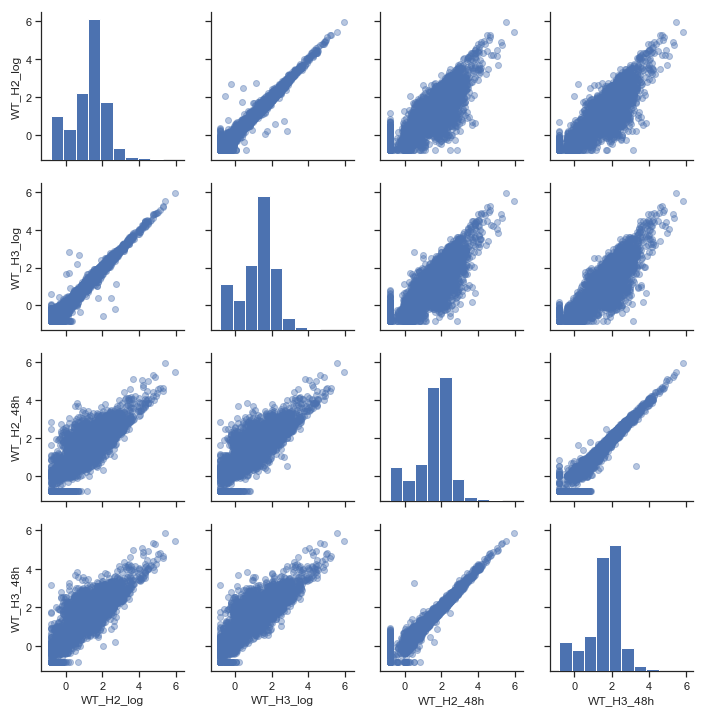

In [12]:
g = sns.PairGrid(intron_data_WT_norm_log10)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, alpha = 0.4)

In [19]:
for cond in ['log','48h']:
    intron_data_WT_norm_log10['WT_' + cond] = intron_data_WT_norm_log10.loc[:,['WT_H2_' + cond, 'WT_H3_' + cond]].mean(axis=1)

In [22]:
#Load ICO seq data 

# Load raw data, process, save as .csv  Only need to do once. 

ARO4_lib_data = pd.read_table(data_processing_dir + "out_gene_exon_tagged_2000.dge.txt")
ARO4_lib_data.set_index('GENE', inplace = True)

#Update gene names to current SGD names
ico_seq_synonyms = pd.read_csv(data_processing_dir + "ICO_seq_common_name_mismatches.csv")
ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
ARO4_lib_data.rename(index =ico_seq_synonyms_dict, inplace = True)


#1. Select only colonies containing at least 500 genes that have at least 1 count.  This brings the total number
#   of colonies down to 1642

mincounts = 1 
ngenes = []
thresh_genes = 500
print('Selecting colonies containing data for at least {0:d} genes with at least {1:d} count'.format(thresh_genes, mincounts))


cells_above_thresh = []
for cell in ARO4_lib_data.columns:
    ngenes_gt_mincounts = len(ARO4_lib_data[cell][ARO4_lib_data[cell]>=mincounts])
    ngenes.append(ngenes_gt_mincounts)
    if ngenes_gt_mincounts >=500: 
        cells_above_thresh.append(cell)

ARO4_lib_data_mincount = ARO4_lib_data.loc[:,cells_above_thresh]


#2. Analyze only genes that have at least N=3 counts in one of the smallest M=300 colonies (as determined by total number of reads)
#   This leaves 1064 genes.  
M = 300
lowcount_thresh = 3

print('Selecting genes that have at least {0:d} counts in one of the smallest {1:d} colonies'.format(lowcount_thresh, M))

#Add a row for total counts and sort descending by that row. 
ARO4_lib_data_mincount_total = ARO4_lib_data_mincount.sum()
ARO4_lib_data_mincount_total.name = 'total_counts'
ARO4_lib_data_mincount = ARO4_lib_data_mincount.append(ARO4_lib_data_mincount_total)
ARO4_lib_data_mincount.sort_values(by='total_counts', axis = 1, ascending = False, inplace=True)
ARO4_lib_data_mincount_genes = ARO4_lib_data_mincount.drop('total_counts')

ARO4_high_exp_genes = ARO4_lib_data_mincount_genes[ARO4_lib_data_mincount_genes.iloc[:, -M:].max(axis = 1)>=lowcount_thresh]


Selecting colonies containing data for at least 500 genes with at least 1 count
Selecting genes that have at least 3 counts in one of the smallest 300 colonies


In [25]:
#Create Average ico_seq datagiven the high exp_genes set and N_scale: 

# 3. Take average for all genes - sum up counts for all colonies, divide by total number of colonies
print('Making average of all counts')
ARO4_high_exp_genes_avg = ARO4_high_exp_genes.sum(axis = 1)/ARO4_high_exp_genes.shape[1]

#4. Normalize by total counts, scale by 10K (the total for the average is about 3300 counts) 
print('Normalizing average by total counts')

#Normalize by total counts, and multipy by median of all counts to ensure scale is close to 
#original counts scale. 
ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg.copy()

ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg_norm/sum(ARO4_high_exp_genes_avg)*N_scale

#5. Add a pseudocount. I use 0.1*sum(ARO4_high_exp_genes_avg)*N_scale 
pseudocount = 0.1/sum(ARO4_high_exp_genes_avg)*N_scale
print('adding psuedocount of {:0.4f}'.format(pseudocount))
ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg_norm + pseudocount
ARO4_high_exp_genes_avg_norm_log10 = np.log10(ARO4_high_exp_genes_avg_norm)

ARO4_high_exp_genes_avg_norm_log10 = pd.DataFrame(ARO4_high_exp_genes_avg_norm_log10, columns=['ico_seq_avg'])
ARO4_high_exp_genes_avg_norm_log10['sc_genename'] = io_library.SC_orf_lookup_by_name(ARO4_high_exp_genes_avg_norm_log10.index)
ARO4_high_exp_genes_avg_norm_log10

Making average of all counts
Normalizing average by total counts
adding psuedocount of 108.2478
S.Cer orf for 15S_rRNAnot found
S.Cer orf for 21S_rRNAnot found
S.Cer orf for CRS5not found
S.Cer orf for RUF5-2not found
S.Cer orf for YAL044W-Anot found
S.Cer orf for YBL005W-Bnot found
S.Cer orf for YBL028Cnot found
S.Cer orf for YBL029C-Anot found
S.Cer orf for YBL039W-Bnot found
S.Cer orf for YBR012W-Bnot found
S.Cer orf for YBR056Wnot found
S.Cer orf for YBR062Cnot found
S.Cer orf for YBR085C-Anot found
S.Cer orf for YBR126W-Anot found
S.Cer orf for YBR137Wnot found
S.Cer orf for YBR191W-Anot found
S.Cer orf for YBR201C-Anot found
S.Cer orf for YBR230W-Anot found
S.Cer orf for YBR255C-Anot found
S.Cer orf for YBR284Wnot found
S.Cer orf for YBR285Wnot found
S.Cer orf for YCL048W-Anot found
S.Cer orf for YCR015Cnot found
S.Cer orf for YCR024C-Bnot found
S.Cer orf for YCR075W-Anot found
S.Cer orf for YCR090Cnot found
S.Cer orf for YDL085C-Anot found
S.Cer orf for YDL121Cnot found
S.Cer or

,ico_seq_avg,sc_genename
GENE,,
15S_rRNA,3.364502,15S_rRNA
21S_rRNA,4.580434,21S_rRNA
ABF2,3.637681,YMR072W
ACB1,3.217195,YGR037C
ACC1,2.810361,YNR016C
SDH7,3.384327,YDR511W
ACT1,3.001518,YFL039C
ADE12,3.031819,YNL220W
ADH1,3.517773,YOL086C


In [26]:
intron_data_WT_ico = intron_data_WT_norm_log10.merge(ARO4_high_exp_genes_avg_norm_log10, how = 'inner', left_index = True, right_on = 'sc_genename')
intron_data_WT_ico

,WT_H2_log,WT_H3_log,WT_H2_48h,WT_H3_48h,WT_log,WT_48h,ico_seq_avg,sc_genename
GENE,,,,,,,,
AI1,3.312923,3.254541,4.075736,4.108090,3.283732,4.091913,3.678256,Q0050
AI2,4.146623,4.044208,5.019831,5.094729,4.095416,5.057280,3.146037,Q0055
AI4,3.237328,3.085914,4.018578,4.173330,3.161621,4.095954,3.189411,Q0065
OLI1,2.355769,2.149515,3.316924,3.507505,2.252642,3.412215,3.794855,Q0130
SCEI,1.242792,0.715223,1.601140,1.780140,0.979008,1.690640,3.284012,Q0160
snR11,2.277974,2.135651,2.545351,2.786787,2.206812,2.666069,2.823883,snR11
snR33,2.471048,2.322776,2.833705,3.224226,2.396912,3.028965,2.871817,snR33
snR49,1.029200,0.985049,1.520006,1.986973,1.007124,1.753489,2.654229,snR49
snR8,2.805695,2.927713,3.594170,3.547822,2.866704,3.570996,2.489478,snR8


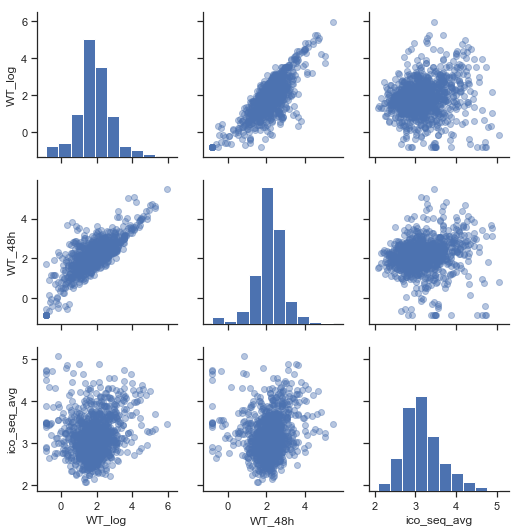

In [29]:
columns_to_view = ['WT_log','WT_48h','ico_seq_avg']
g = sns.PairGrid(intron_data_WT_ico.loc[:,columns_to_view])
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, alpha = 0.4)

0.07605698220248998
3.0133127568601155


Text(0,0.5,'ico_seq_avg')

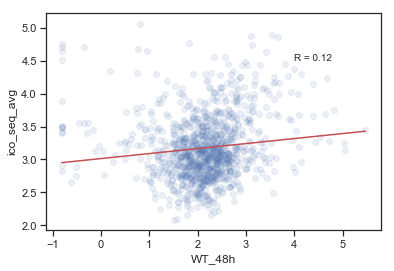

In [33]:
fix, ax = plt.subplots()
xcond = 'WT_48h'
ycond = 'ico_seq_avg'
xvalues =  intron_data_WT_ico[xcond]
#xvalues =  bulk_data_ico_avg_old[cond + ' mean']
yvalues =  intron_data_WT_ico[ycond]
slope, intercept, r_value, p_value, std_err = stats.linregress(xvalues, yvalues)
print(slope)
print(intercept)
ax.scatter(xvalues,yvalues, alpha = 0.1)
minx = min(xvalues)
maxx = max(xvalues)
line_xvals = np.linspace(minx,maxx, num=4)
line_yvals = intercept + slope*line_xvals
ax.plot(line_xvals, line_yvals, 'r')
ax.text(4, 4.5, 'R = {:.2f}'.format(r_value))
ax.set_xlabel(xcond)
ax.set_ylabel(ycond)